# UC San Diego: Data Science in Practice - EDA Checkpoint
### Summer Session I 2023 | Instructor : C. Alex Simpkins Ph.D.

## Identifying Relationships in Diabetes Clinical Data Towards Predicting Blood Glucose Levels.

(This checkpoint helps you to perform your EDA on your data for your project. You can remove this text description. Consider this the next step in your final project. See the project readme for bullet points to check off in terms of details to include beyond the main section heading content below.)

# Names

- Conner Hsu
- Harshita Saha
- Sidharth Srinath
- Anastasiya Markova

<a id='research_question'></a>
# Research Question

Given clinical data for cohorts with and without diabetes, which feature most correlates to the measure of 'blood_glucose_level' for each cohort, and are they different between the cohorts?

# Setup and Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Data Cleaning

Describe your data cleaning steps here.

In [3]:
# check if there is any missing data
df.isna().sum().sum()

0

In [4]:
# check the datatypes of each column
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [5]:
# checking gender of patients
df.groupby('gender').count()['age']

gender
Female    58552
Male      41430
Other        18
Name: age, dtype: int64

In [6]:
# removing records where gender is not specified/recorded as it may affect predictions
df = df[df['gender'] != 'Other']
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [7]:
# removing records for patients less than 20
# this is because the rates of diabetes are lower in these populations
# and diabetes is less well studied as a result, and analyis based 
# on these groups might not generalizable
# https://www.cdc.gov/diabetes/data/statistics-report/newly-diagnosed-diabetes.html
# https://diabetesjournals.org/care/article/46/3/490/148482/Youth-Onset-Type-2-Diabetes-The-Epidemiology-of-an
df = df[df['age'] >= 20]
df.shape

(80321, 9)

In [8]:
# bmi labeling
bmi_bins = pd.cut(df['bmi'], [0, 18.5, 25, 30, round(df['bmi'].max())], right=False, \
                  labels=['underweight', 'healthy', 'overweight', 'obese']) 
df['bmi_label'] = bmi_bins

In [9]:
# blood_glucose labeling
bg_bins = pd.cut(df['blood_glucose_level'], [0, 90, 130, round(df['blood_glucose_level'].max())], right=False, \
                 labels=['low', 'normal', 'high'])
df['bg_label'] = bg_bins

In [10]:
# HbA1c labeling
age_bins = pd.cut(df['age'], [19, 39, 59, round(df['age'].max())], labels=['g1', 'g2', 'g3'])
df['age_label'] = age_bins

#setting up thresholds for HbA1c levels
conditions = [df['age_label']=='g1', df['age_label']=='g2', df['age_label']=='g3']
choices = [6.0, 6.1, 6.5]
HbA1c_exp = np.select(conditions, choices)
df['HbA1c_label'] = HbA1c_exp

#assigning high/normal based on the thresholds and current HbA1c levels
df['HbA1c_label'] = (df['HbA1c_level'] <= df['HbA1c_label']).replace({True:'normal', False:'high'})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_label,bg_label,age_label,HbA1c_label
0,Female,80.0,0,1,never,25.19,6.6,140,0,overweight,high,g3,high
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,overweight,low,g2,high
2,Male,28.0,0,0,never,27.32,5.7,158,0,overweight,high,g1,normal
3,Female,36.0,0,0,current,23.45,5.0,155,0,healthy,high,g1,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,healthy,high,g3,normal


In [11]:
#reorderingthe columns
df = df[list(df.columns[:6])+['bmi_label', 'HbA1c_level', 'HbA1c_label', 'blood_glucose_level', 'bg_label', 'diabetes']]
#renaming the columns
df = df.rename(columns={"HbA1c_level": "hba1c", "HbA1c_label": "hba1c_label", "blood_glucose_level": "bg"})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,bmi_label,hba1c,hba1c_label,bg,bg_label,diabetes
0,Female,80.0,0,1,never,25.19,overweight,6.6,high,140,high,0
1,Female,54.0,0,0,No Info,27.32,overweight,6.6,high,80,low,0
2,Male,28.0,0,0,never,27.32,overweight,5.7,normal,158,high,0
3,Female,36.0,0,0,current,23.45,healthy,5.0,normal,155,high,0
4,Male,76.0,1,1,current,20.14,healthy,4.8,normal,155,high,0


In [12]:
df0 = df[df['diabetes'] == 0]
df1 = df[df['diabetes'] == 1]

In [13]:
# create age group bins to explore features by age group
# justify and/or change ages chosen here
bins = pd.cut(df['age'], [0, 5, 13, 18, 30, 45, 60, 80]) 
df['age_group'] = bins

df

,gender,age,hypertension,heart_disease,smoking_history,bmi,bmi_label,hba1c,hba1c_label,bg,bg_label,diabetes,age_group
0,Female,80.0,0,1,never,25.19,overweight,6.6,high,140,high,0,"(60, 80]"
1,Female,54.0,0,0,No Info,27.32,overweight,6.6,high,80,low,0,"(45, 60]"
2,Male,28.0,0,0,never,27.32,overweight,5.7,normal,158,high,0,"(18, 30]"
3,Female,36.0,0,0,current,23.45,healthy,5.0,normal,155,high,0,"(30, 45]"
4,Male,76.0,1,1,current,20.14,healthy,4.8,normal,155,high,0,"(60, 80]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,Female,36.0,0,0,No Info,24.60,healthy,4.8,normal,145,high,0,"(30, 45]"
99995,Female,80.0,0,0,No Info,27.32,overweight,6.2,normal,90,normal,0,"(60, 80]"
99997,Male,66.0,0,0,former,27.83,overweight,5.7,normal,155,high,0,"(60, 80]"
99998,Female,24.0,0,0,never,35.42,obese,4.0,normal,100,normal,0,"(18, 30]"


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [14]:
df.describe()

,age,hypertension,heart_disease,bmi,hba1c,bg,diabetes
count,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000
mean,49.782946,0.093064,0.049003,28.711241,5.555272,139.280101,0.104506
std,17.478788,0.290524,0.215876,6.057741,1.090123,41.974772,0.305917
min,20.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,35.000000,0.000000,0.000000,25.700000,4.800000,100.000000,0.000000
50%,49.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,63.000000,0.000000,0.000000,30.750000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000


In [15]:
# proportion of 'hypertension', 'heart_disease', 'diabetes' by gender
#df.groupby(['gender']).agg('mean')[['hypertension', 'heart_disease', 'diabetes']]
list(df.columns)

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'smoking_history',
 'bmi',
 'bmi_label',
 'hba1c',
 'hba1c_label',
 'bg',
 'bg_label',
 'diabetes',
 'age_group']

In [16]:
df.dtypes

gender               object
age                 float64
hypertension          int64
heart_disease         int64
smoking_history      object
bmi                 float64
bmi_label          category
hba1c               float64
hba1c_label          object
bg                    int64
bg_label           category
diabetes              int64
age_group          category
dtype: object

## Bar Charts

/Users/sidharthsrinath/.pyenv/versions/3.9.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sidharthsrinath/.pyenv/versions/3.9.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


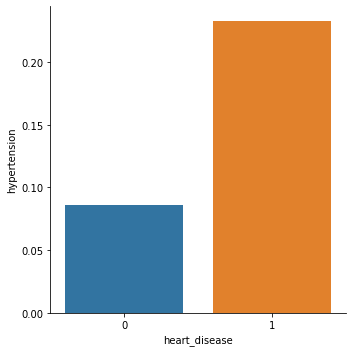

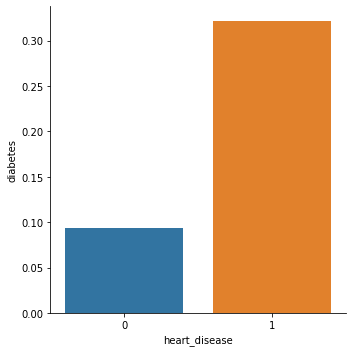

In [17]:
tmp = df.groupby(['heart_disease'])[['hypertension', 'diabetes']].mean()

# tmp = df.groupby('heart_disease')['hypertension', 'diabetes'].mean()
tmp.reset_index(inplace=True)
sns.catplot(data=tmp, kind="bar", x='heart_disease', y="hypertension")
sns.catplot(data=tmp, kind="bar", x='heart_disease', y='diabetes')

/Users/sidharthsrinath/.pyenv/versions/3.9.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sidharthsrinath/.pyenv/versions/3.9.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


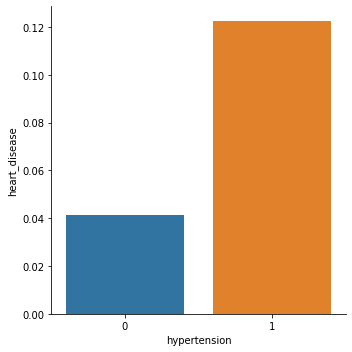

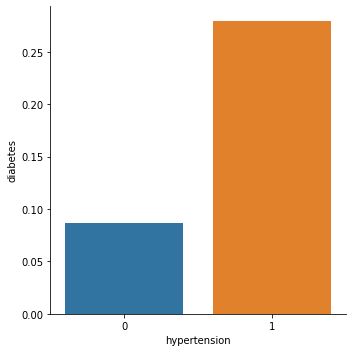

In [18]:
# proportion of 'heart_disease', 'diabetes' by hypertension status
tmp = df.groupby(['hypertension'])[['heart_disease', 'diabetes']].mean()
tmp.reset_index(inplace=True)
sns.catplot(data=tmp, kind="bar", x='hypertension', y="heart_disease")
sns.catplot(data=tmp, kind="bar", x='hypertension', y='diabetes')

<Axes: xlabel='diabetes', ylabel='proportion'>

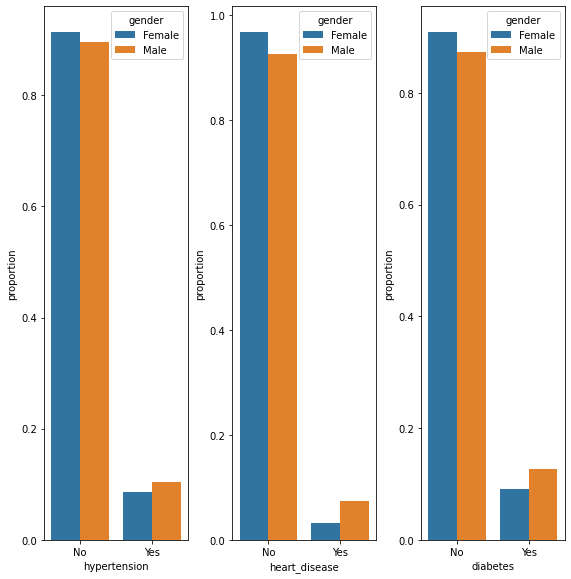

In [19]:
gen_hyp = (df.groupby(['gender'])['hypertension']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .rename({0:'No',1:"Yes"})
                        .reset_index()
)
gen_hd = (df.groupby(['gender'])['heart_disease']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .rename({0:'No',1:"Yes"})
                        .reset_index()
)
gen_d = (df.groupby(['gender'])['diabetes']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .rename({0:'No',1:"Yes"})
                        .reset_index()
)
fig, axs = plt.subplots(ncols=3,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='hypertension',y='proportion',hue='gender',data=gen_hyp,ax=axs[0])
sns.barplot(x='heart_disease',y='proportion',hue='gender',data=gen_hd,ax=axs[1])
sns.barplot(x='diabetes',y='proportion',hue='gender',data=gen_d,ax=axs[2])

Here we can see that females are represented more than males in incidences of hypertension, heart disease, and diabetes

Here we can see:
1. Females are represented more than males across most ages.
2. Females are represnted more than males across all bmis.
3. Females are represented more than males across higher hba1c levels and similarly with males in lower levels.
4. Females are represnted more than males across all bg levels.

<Axes: xlabel='labels', ylabel='heart_disease'>

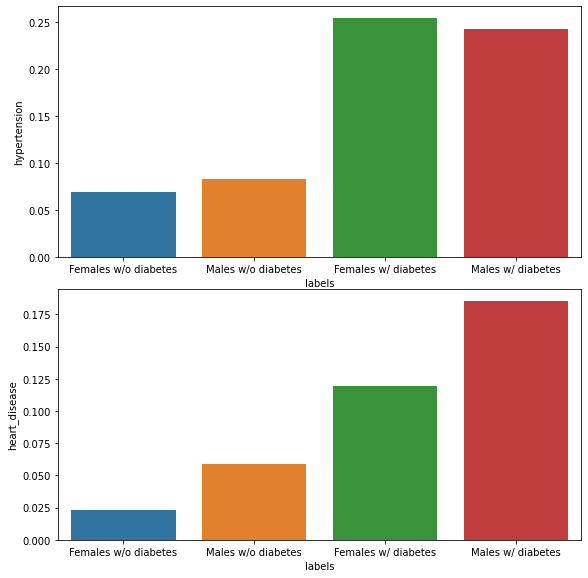

In [20]:
# proportion of 'hypertension', 'heart_disease' by diabetes status and gender
dg_hthd = df.groupby(['diabetes', 'gender'])[['hypertension', 'heart_disease']].mean().rename({'Female':1,'Male':0}).reset_index()
labels = ['Females w/o diabetes','Males w/o diabetes','Females w/ diabetes', 'Males w/ diabetes']
dg_hthd['labels'] = labels
fig, axs = plt.subplots(nrows=2,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='labels',y='hypertension',data=dg_hthd, ax=axs[0])
sns.barplot(x='labels',y='heart_disease',data=dg_hthd, ax=axs[1])

Here we can see that females w/ diabetes are represented more than males w/ diabetes in incidences of hypertension males w/diabetes are represnted more than females w/ diabetes in incidences of heart disease.

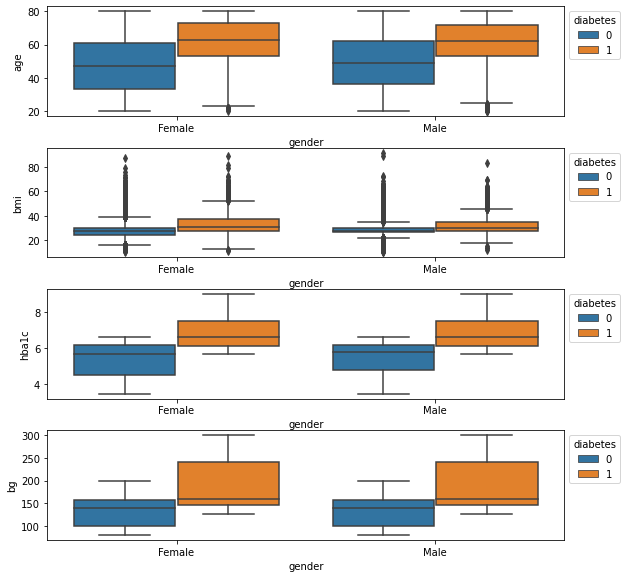

In [21]:
data2 = df[['diabetes','gender','age', 'bmi', 'hba1c', 'bg']]

fig, axs = plt.subplots(nrows=4,figsize=(8,8))
fig.tight_layout()
#fix legend

sns.boxplot(x='gender',y='age', hue='diabetes', data=data2, ax=axs[0])
sns.boxplot(x='gender',y='bmi',  hue='diabetes', data=data2, ax=axs[1])
sns.boxplot(x='gender',y='hba1c', hue='diabetes', data=data2, ax=axs[2])
sns.boxplot(x='gender',y='bg', hue='diabetes', data=data2, ax=axs[3])

sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[3], "upper left", bbox_to_anchor=(1, 1))


Here we can see that across females and males w/ and w/o diabetes, those in either sex with diabetes are represented more than those without for features, age, bmi, hba1c level, and blood glucose level. Additionally, we can see that there is not much of a difference in representation across these features between sexes.

In [22]:
# create age group bins to explore features by age group
# justify and/or change ages chosen here
# bins = pd.cut(df['age'], [0, 5, 13, 18, 30, 45, 60, 80]) 
# df['age_group'] = bins

<Axes: xlabel='age_group', ylabel='diabetes'>

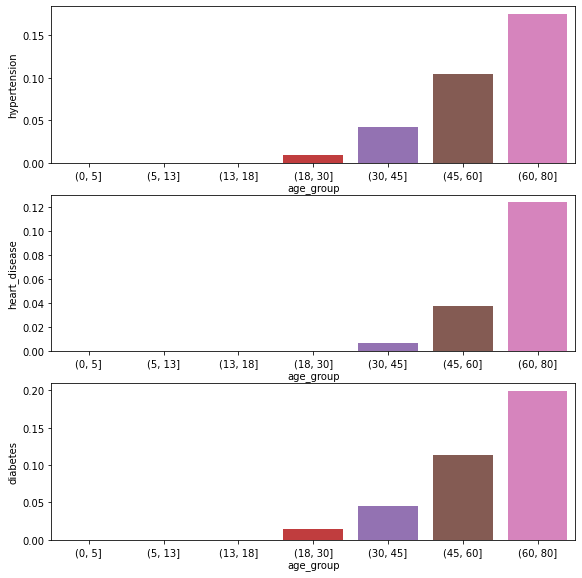

In [23]:
# proportion of 'hypertension', 'heart_disease', 'diabetes' by age group
data3 = df.groupby(['age_group'])[['hypertension', 'heart_disease','diabetes']].mean().reset_index()

fig, axs = plt.subplots(nrows=3,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='age_group',y='hypertension',data=data3,ax=axs[0])
sns.barplot(x='age_group',y='heart_disease',data=data3,ax=axs[1])
sns.barplot(x='age_group',y='diabetes',data=data3,ax=axs[2])

Here we can see that inidividuals under 18 have been dropped from the dataset, and as age rises, incidences of heart disease and hypertension rise as well.

<Axes: xlabel='age_group', ylabel='bg'>

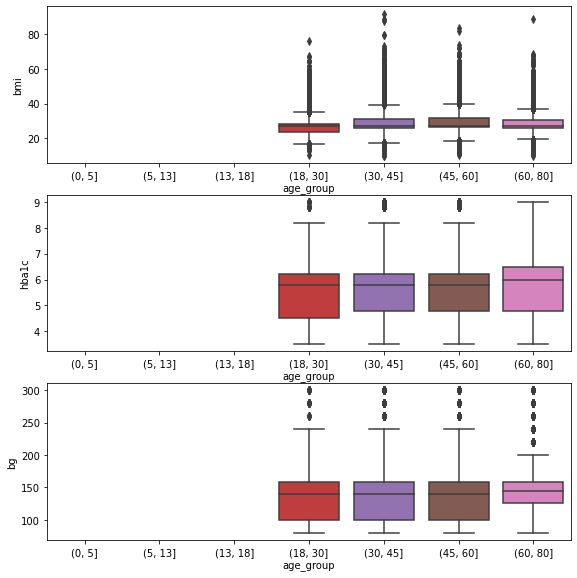

In [24]:
# average 'bmi', 'HbA1c_level', 'blood_glucose_level' by age group
data4 = df[['age_group','bmi', 'hba1c', 'bg']] # or median

fig, axs = plt.subplots(nrows=3,figsize=(8,8))
fig.tight_layout()
sns.boxplot(x='age_group',y='bmi',data=data4, ax=axs[0])
sns.boxplot(x='age_group',y='hba1c',data=data4, ax=axs[1])
sns.boxplot(x='age_group',y='bg',data=data4, ax=axs[2])

Here we can see that values of bmi, hba1c level, and blood glucose level remain consistent across adult age groups.

<Axes: xlabel='hypertension', ylabel='diabetes'>

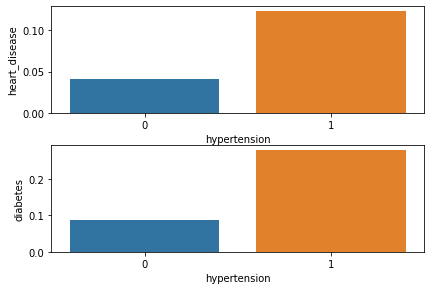

In [25]:
# proportion of 'heart_disease', 'diabetes' by hypertension status
data5 = df.groupby('hypertension')[['heart_disease', 'diabetes']].mean().reset_index().rename({0:'no hypertension',1:'hypertension'})

fig, axs = plt.subplots(nrows=2)
fig.tight_layout()
sns.barplot(x='hypertension',y='heart_disease',data=data5, ax=axs[0])
sns.barplot(x='hypertension',y='diabetes',data=data5, ax=axs[1])

These graphs illustrate that individuals with hypertension are represnted more than those without in groups with heart disease and diabetes.

<Axes: xlabel='heart_disease', ylabel='diabetes'>

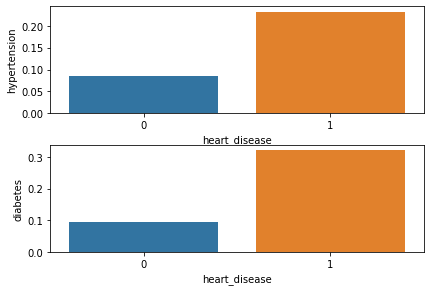

In [26]:
# proportion of 'hypertension', 'diabetes' by heart_disease status
data6 = df.groupby('heart_disease')[['hypertension', 'diabetes']].mean().reset_index()

fig, axs = plt.subplots(nrows=2)
fig.tight_layout()
sns.barplot(x='heart_disease',y='hypertension',data=data6, ax=axs[0])
sns.barplot(x='heart_disease',y='diabetes',data=data6, ax=axs[1])

These graphs illustrate that individuals with heart disease are represnted more than those without in groups with hypertension and diabetes.

## Boxplots, Correlations, and Clusters

In [27]:
df_sub = df[['diabetes', 'bmi', 'hba1c', 'bg']]
df0 = df_sub[df_sub['diabetes']==0]
df1 = df_sub[df_sub['diabetes']==1]

<Axes: xlabel='diabetes', ylabel='hba1c'>

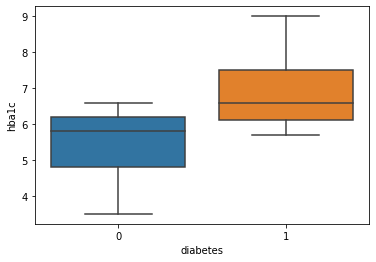

In [28]:
sns.boxplot(x='diabetes', y='hba1c', data=df_sub)

Above we can see that HbA1c levels are higher for those with diabetes than those without.

<Axes: xlabel='diabetes', ylabel='bmi'>

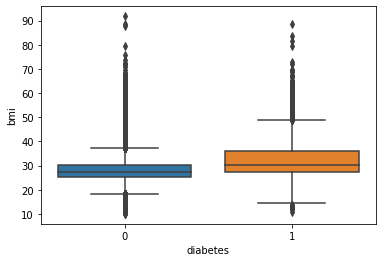

In [29]:
sns.boxplot(x='diabetes', y='bmi', data=df_sub)

Here we can see that the bmi of those with diabetes is slightly higher than those without.

<Axes: xlabel='diabetes', ylabel='bg'>

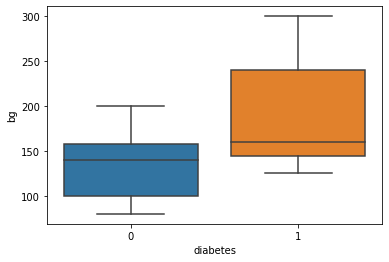

In [30]:
sns.boxplot(x='diabetes', y='bg', data=df_sub)

Similar to the patterns observed in HbA1c levels separated by diabetes status, blood glucose levels are higehr in those with diabetes than in those without.

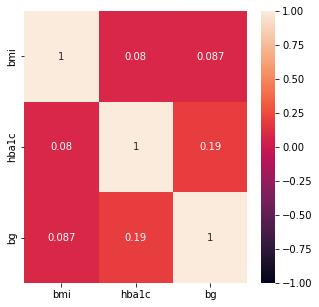

In [31]:
# creating correlation plot for entire dataset
corr = df_sub[['bmi', 'hba1c', 'bg']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, vmin=-1)
plt.show()

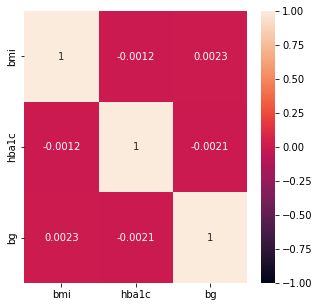

In [32]:
# creating correlation plot for those without diabetes
corr = df0[['bmi', 'hba1c', 'bg']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, vmin=-1)
plt.show()

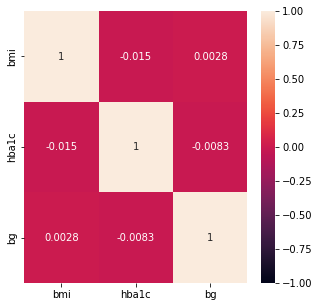

In [33]:
# creating correlation plot for those with diabetes
corr = df1[['bmi', 'hba1c', 'bg']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, vmin=-1)
plt.show()

As seen in the plots above, focusing on the features of bmi, hba1c, and bg by diabetes status, when taking the entire dataset, bg is correlated more highly to hba1c than bmi (0.19 and 0.087 respectively). For the subset of patients without diabetes, bg was slightly more correlated to bmi than hba1c (0.0023 and -0.0021 respectively), while for those with diabetes bg was slightly more correlated to hba1c than bmi (-0.0083 and 0.0028 respectively). Interestingly, hba1c and bmi are both positively correlated to bg when taking the entire dataset, but when considering subsets by diabetes status, bmi is positively correlated while hba1c is negatively correlated. The correlations also indicate a much weaker relationship in the subsets than when analyzing entire dataset.

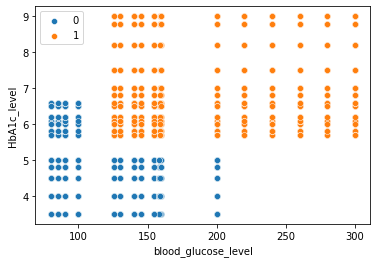

In [34]:
# seeing 2d clustering of datapoints, bg vs hba1c
ax = plt.subplots()
ax = sns.scatterplot(x='bg', y='hba1c', data=df0, label='0')
ax = sns.scatterplot(x='bg', y='hba1c', data=df1, label='1')
ax.set(xlabel='blood_glucose_level', ylabel='HbA1c_level')
ax.legend()
plt.show()

Here we can see that patients with diabetes have higher hba1c levels at the same blood glucose levels as those without diabetes, and similarly patients with diabetes have higher blood glucose levels at the same hba1c levels as those without diabetes. The datapoints of those with diabetes have higher blood glucose levels and hba1c levels than those without diabetes. The values across which the groups appear to separate are hba1c$\approx$5.6 to 6.6 and bg$\approx$125 to 200. The diabetic patients cluster to the top right of this plot.

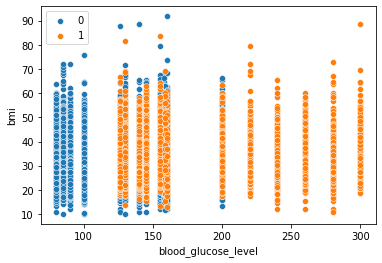

In [35]:
# seeing 2d clustering of datapoints, bg vs bmi
ax = plt.subplots()
ax = sns.scatterplot(x='bg', y='bmi', data=df0, label='0')
ax = sns.scatterplot(x='bg', y='bmi', data=df1, label='1')
ax.set(xlabel='blood_glucose_level', ylabel='bmi')
ax.legend()
plt.show()

Here we can see that patients with diabetes have higher bg levels at the same bmi than those without diabetes, but at the same blood glucose level, those with diabetes do not necessarily have a higher bmi. The datapoints of those with diabetes have higher blood glucose levels than those without diabetes. The values across which the groups appear to separate are bg$\approx$125 to 200. The diabetic patients cluster to the right of this plot.

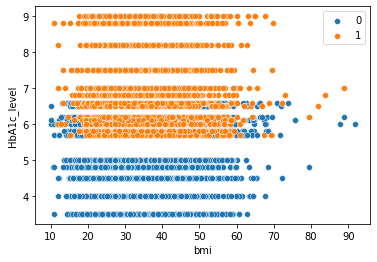

In [36]:
# seeing 2d clustering of datapoints, hba1c vs bmi
ax = plt.subplots()
ax = sns.scatterplot(x='bmi', y='hba1c', data=df0, label='0')
ax = sns.scatterplot(x='bmi', y='hba1c', data=df1, label='1')
ax.set(xlabel='bmi', ylabel='HbA1c_level')
ax.legend()
plt.show()

Here we can see that patients with diabetes have higher hba1c levels at the same bmi than those without diabetes, but at the same hba1c, those with diabetes do not necessarily have a higher bmi. The datapoints of those with diabetes have higher hba1c levels than those without diabetes. The values across which the groups appear to separate are hba1c$\approx$5.6 to 6.6. The diabetic patients cluster to the top of this plot.

In [37]:
# creating a 3d plot to see bmi vs bg vs hba1c
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X1,Y1,Z1 = zip(*[(x,y,z) for x,y,z in zip(df0['bmi'], df0['bg'], df0['hba1c'])])
X2,Y2,Z2 = zip(*[(x,y,z) for x,y,z in zip(df1['bmi'], df1['bg'], df1['hba1c'])])

ax.scatter(X1, Y1, Z1, c='b', marker='x', label='0')   
ax.scatter(X2, Y2, Z2, c='orange', marker='o', label='1')
ax.set_xlabel('bmi')
ax.set_ylabel('bg')
ax.set_zlabel('hba1c')
ax.legend()
plt.show()

<IPython.core.display.Javascript object>

As seen in the plot above, datapoints for patients with and without diabetes appear to cluster most differently along the axes of bg and hba1c. This is corroborated by the conclusions drawn from the 2d scatterplots shown prior to this 3d visualization. This means that bg and hba1c are the features that most set the two groups apart are bg and hba1c levels, in comparison to bmi values. 

In [38]:
# creating a 4d plot to see bmi vs bg vs hba1c vs age
df_sub = df[['diabetes', 'bmi', 'hba1c', 'bg', 'age']]
df_0 = df_sub[df_sub['diabetes']==0]
df_1 = df_sub[df_sub['diabetes']==1]

fig_4d = plt.figure()
ax = fig_4d.add_subplot(projection='3d')


X1,Y1,Z1,C1 = zip(*[(x,y,z,c) for x,y,z,c in zip(df_0['bmi'], df_0['bg'], df_0['hba1c'], df_0['age'])])
X2,Y2,Z2,C2 = zip(*[(x,y,z,c) for x,y,z,c in zip(df_1['bmi'], df_1['bg'], df_1['hba1c'], df_1['age'])])

img = ax.scatter(X1, Y1, Z1, c=C1, marker='x', label='0') 
img = ax.scatter(X2, Y2, Z2, c=C2, marker='o', label='1')
  
ax.set_xlabel('bmi')
ax.set_ylabel('bg')
ax.set_zlabel('hba1c')
fig_4d.colorbar(img)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>

In the plot above, in addition to the variables visualized in the previos 3d plot, the 4th feature of age is included using the color density. In addition to the conclusion drawn for the previous plot, which are still seen here, it appears that patients with diabetes are a lot older than those without diabetes. However, it is not immediately apparent from this plot as to whether or not there are specific clusters by age group within clusters of patients with and without diabetes when it comes to bmi, bg, and hba1c values.

## A/B Testing

#### Preparing

In [39]:
#resample the diabetes patients so that our data is less skewed
n = df.shape[0] - (df['diabetes'] == 1).sum()
#since the data has many more patients without diabetes than with diabetes this can skew our A/B, so we took a random
#sample of the the people with diabetes to create an even split of those with and without diabetes.
sapmle_df = df[df['diabetes'] == 1].sample(n=n, replace=True)
sample_df = pd.concat([sapmle_df, df[df['diabetes'] == 0]], ignore_index=True)

In [40]:
#finding average values of all numeric columns for people with and without diabetes
df_observed = sample_df.groupby('diabetes')['bg', 'hba1c', 'bmi', 'age'].mean()

#difference in means
diffs = abs(df_observed.diff(axis=0))
diffs

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [ ]:
#This is the function to find absolute difference in means
def abs_diff_means(df, col):
    means = df.groupby('diabetes')[col].mean()
    diff = (abs(means.diff()))
    return diff.loc[1]

In [ ]:
#This fucntion performs a permutation test
def permutation(df, col):
    copy = df[['diabetes', col]]
    diffs = []
    for i in range(100):
        copy['diabetes'] = np.random.permutation(copy['diabetes'])
        diffs.append(abs_diff_means(copy, col))

    return diffs


#### Blood Glucose Levels

Null: The `blood glucose` levels of patients with and without diabetes have the same distribution

Alternative: The `blood glucose` levels of the patients with and without diabetes come from different distributions

In [ ]:
bg_observed = diffs.iloc[1,0]

In [ ]:
#Plot the Distributions of Blood Glucose Levels for Diabetes and Non-Diabetes Patients
ax = plt.subplot()
ax.set_xlabel('Blood Glucose Levels')
sns.histplot(x='bg', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title='Distribution of Blood Glucose Levels For Diabetes/Non-Diabetes Patients')

[Text(0.5, 1.0, 'Distribution of Blood Glucose Levels For Diabetes/Non-Diabetes Patients')]

<IPython.core.display.Javascript object>


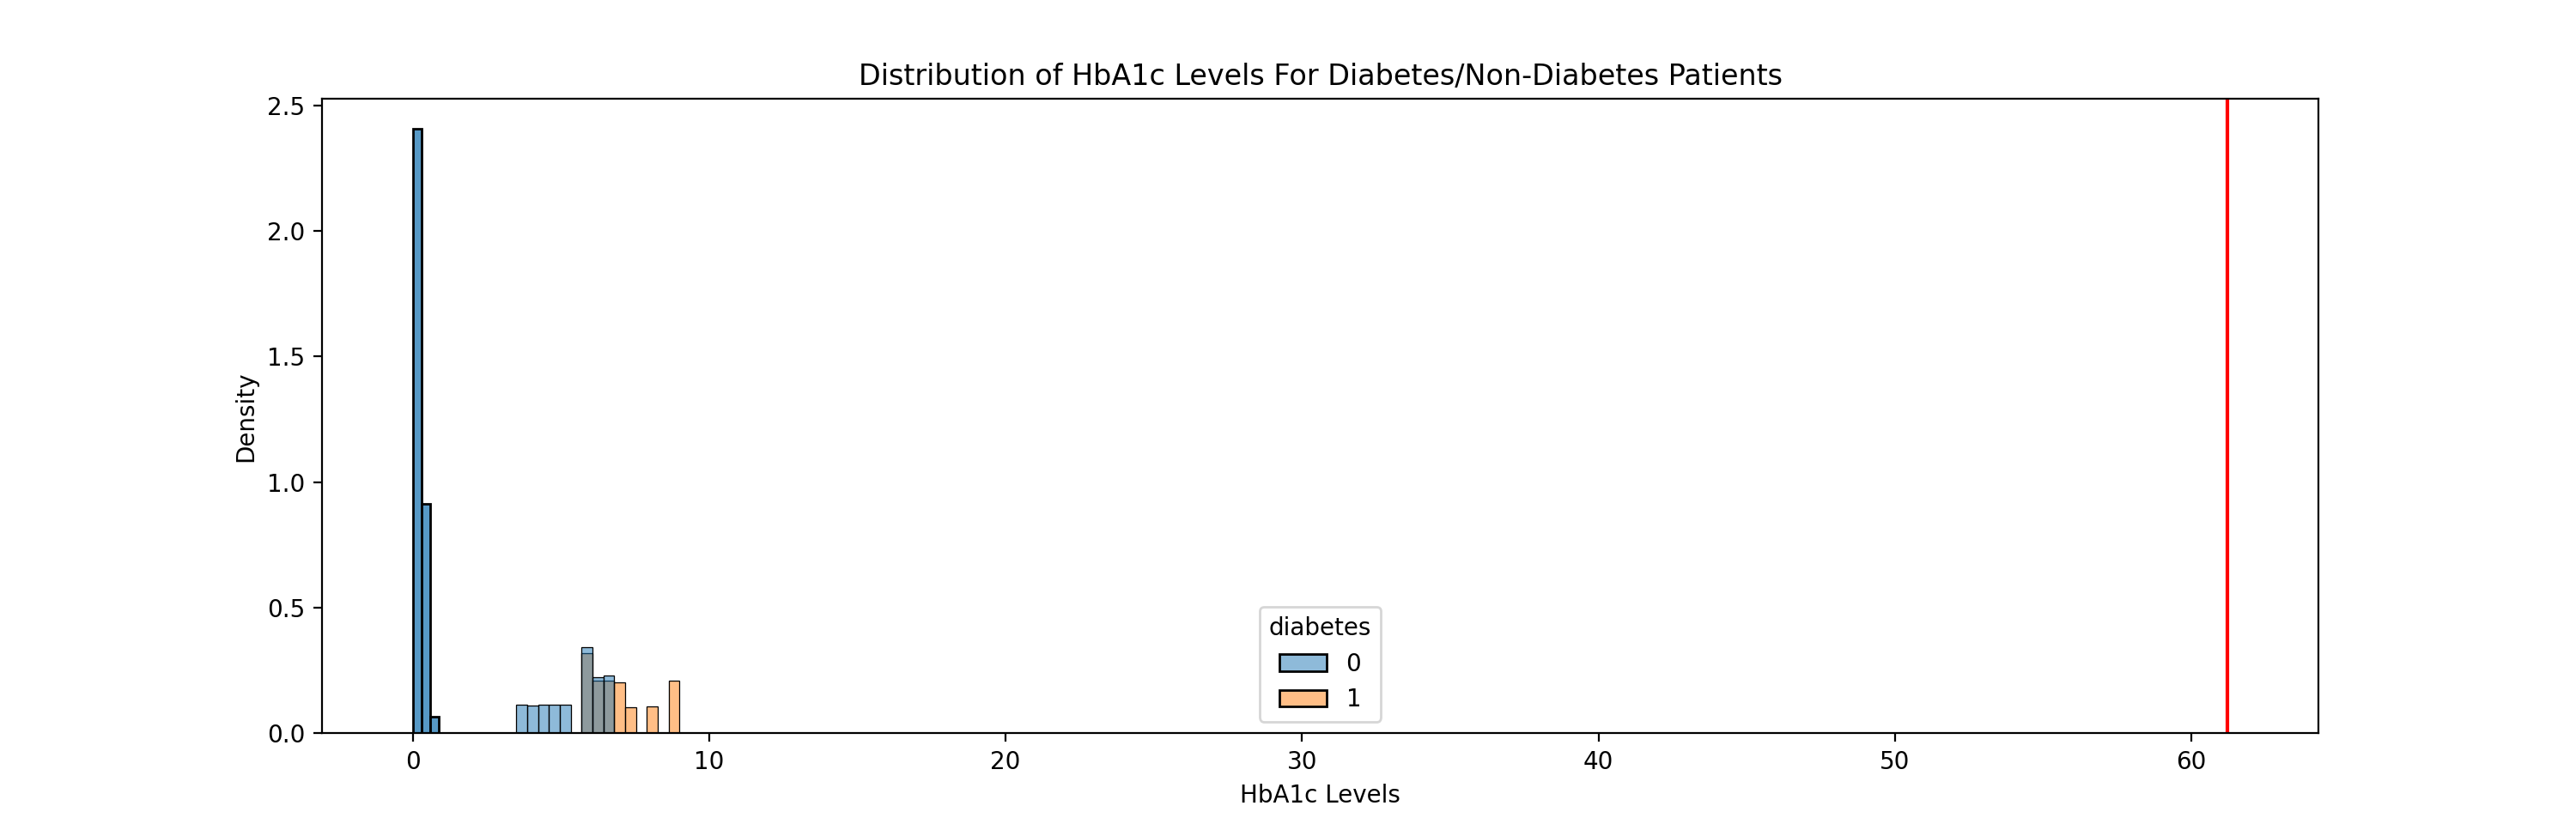

In [ ]:
#we find the results of our permutation test and plot them
fig1, ax1 = plt.subplots()
perm_diffs_bg = permutation(sample_df, 'bg')
sns.histplot(data = perm_diffs_bg, stat='density', bins=3).set(title='Distribution of Mean Absolute Differences')
plt.axvline(bg_observed, color='red')
ax.set_xlabel('Absolute Difference in Means')
fig1.set_figwidth(15) 


In [ ]:
#this calculates the p-value for the permutation test on blood glucose level
p_value_bg = (perm_diffs_bg >= bg_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the blood_glucose levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### HbA1c Levels

Null: The `hba1c` levels of patients with and without diabetes have the same distribution

Alternative: The `hba1c` levels of the patients with and without diabetes come from different distributions


In [ ]:
#Distribution of the HbA1c Levels for people with and without Diabetes
ax = plt.subplot()
ax.set_xlabel('HbA1c Levels')
sns.histplot(x='hba1c', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title="Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients")

[Text(0.5, 1.0, 'Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients')]

In [ ]:
#Our observed test statistic for hba1c levels
hba1c_observed = diffs.iloc[1,1]

<IPython.core.display.Javascript object>


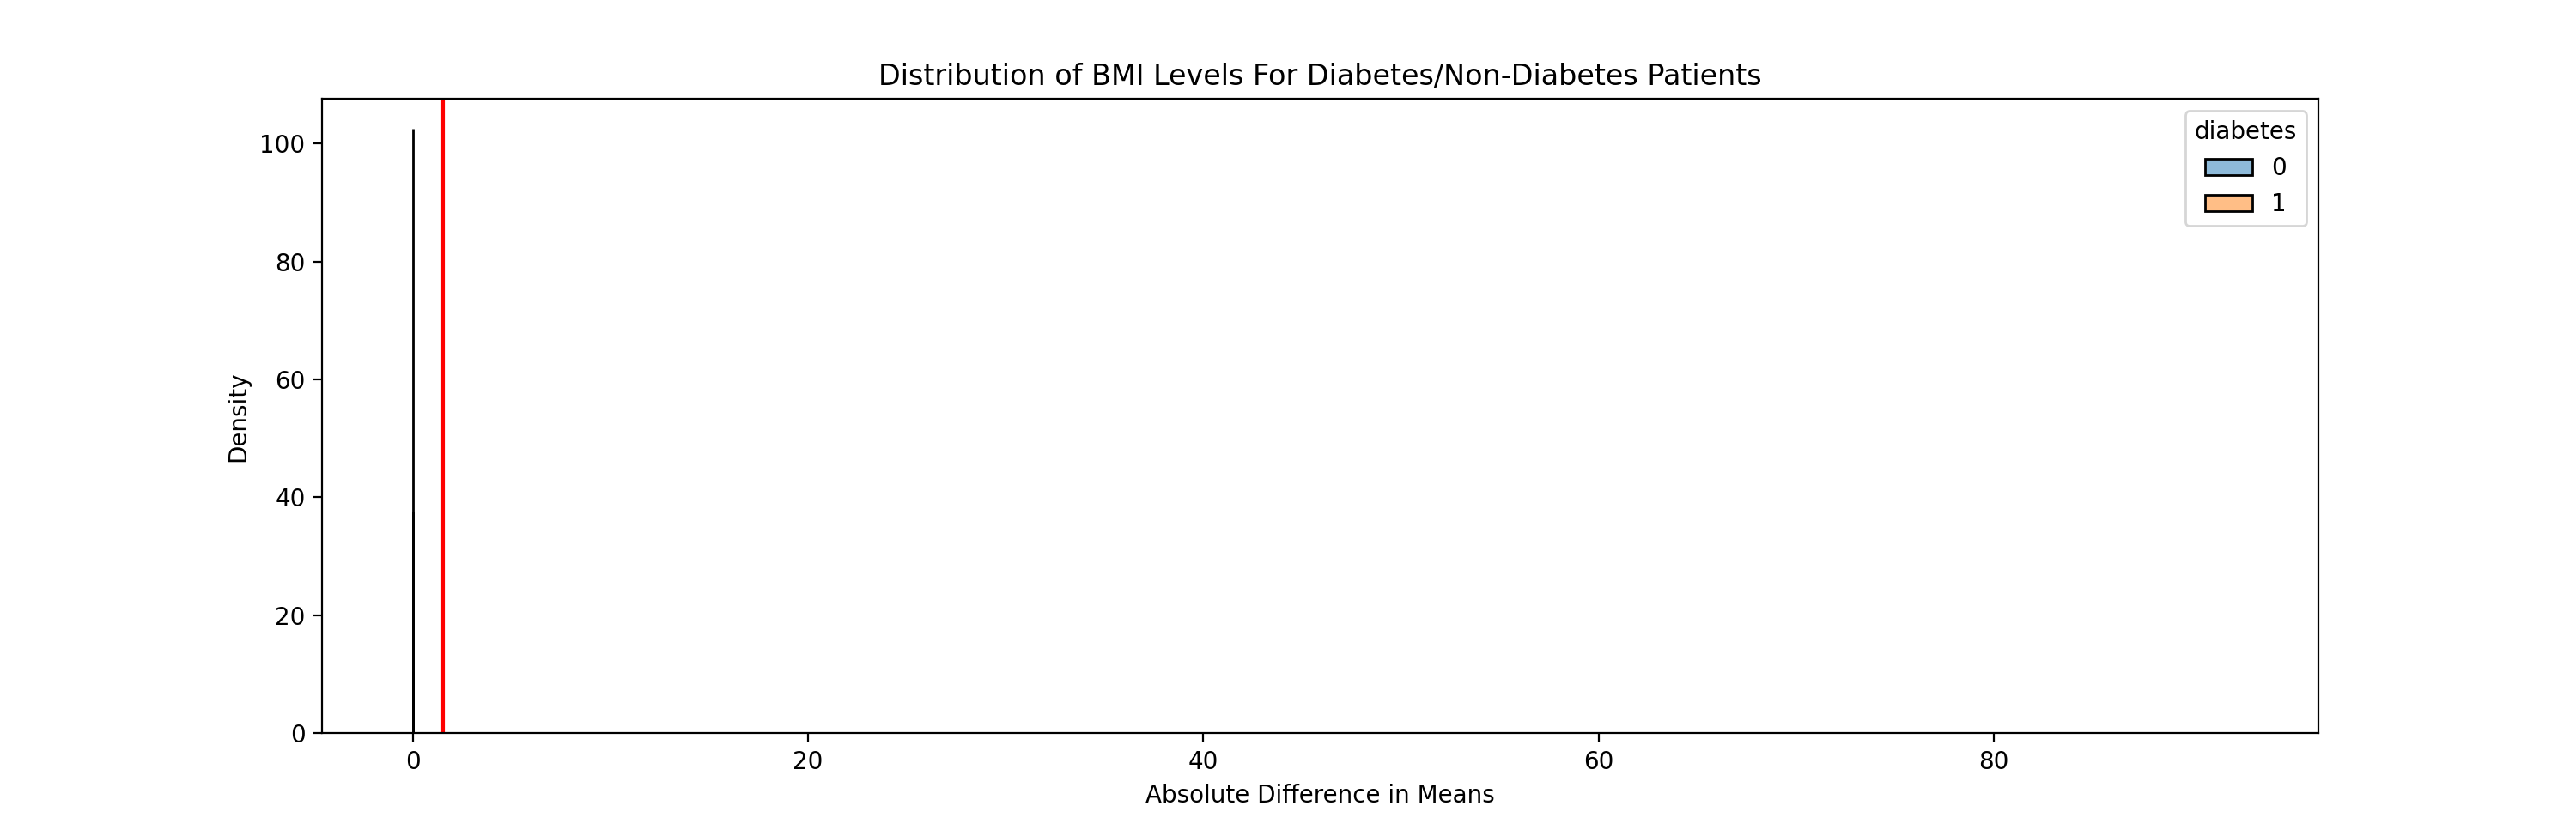

In [ ]:
#The result of our permutation tests
perm_diffs = permutation(sample_df, 'hba1c')
fig2, ax2 = plt.subplots()
ax2.set_xlabel('Absolute Difference in Means')
sns.histplot(data = perm_diffs, stat='density', bins=3).set(title='Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients')
plt.axvline(hba1c_observed, color='red')
fig2.set_figwidth(15) 

In [ ]:
#This is the p value for hba1c levels
p_value_bg = (perm_diffs >= hba1c_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the hba1c levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### BMI Levels

Null: The `bmi` levels of patients with and without diabetes have the same distribution

Alternative: The `bmi` levels of the patients with and without diabetes come from different distributions

In [ ]:
sns.histplot(x='bmi', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title='Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')

[Text(0.5, 1.0, 'Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')]

In [ ]:
bmi_observed = diffs.iloc[1,2]

<IPython.core.display.Javascript object>


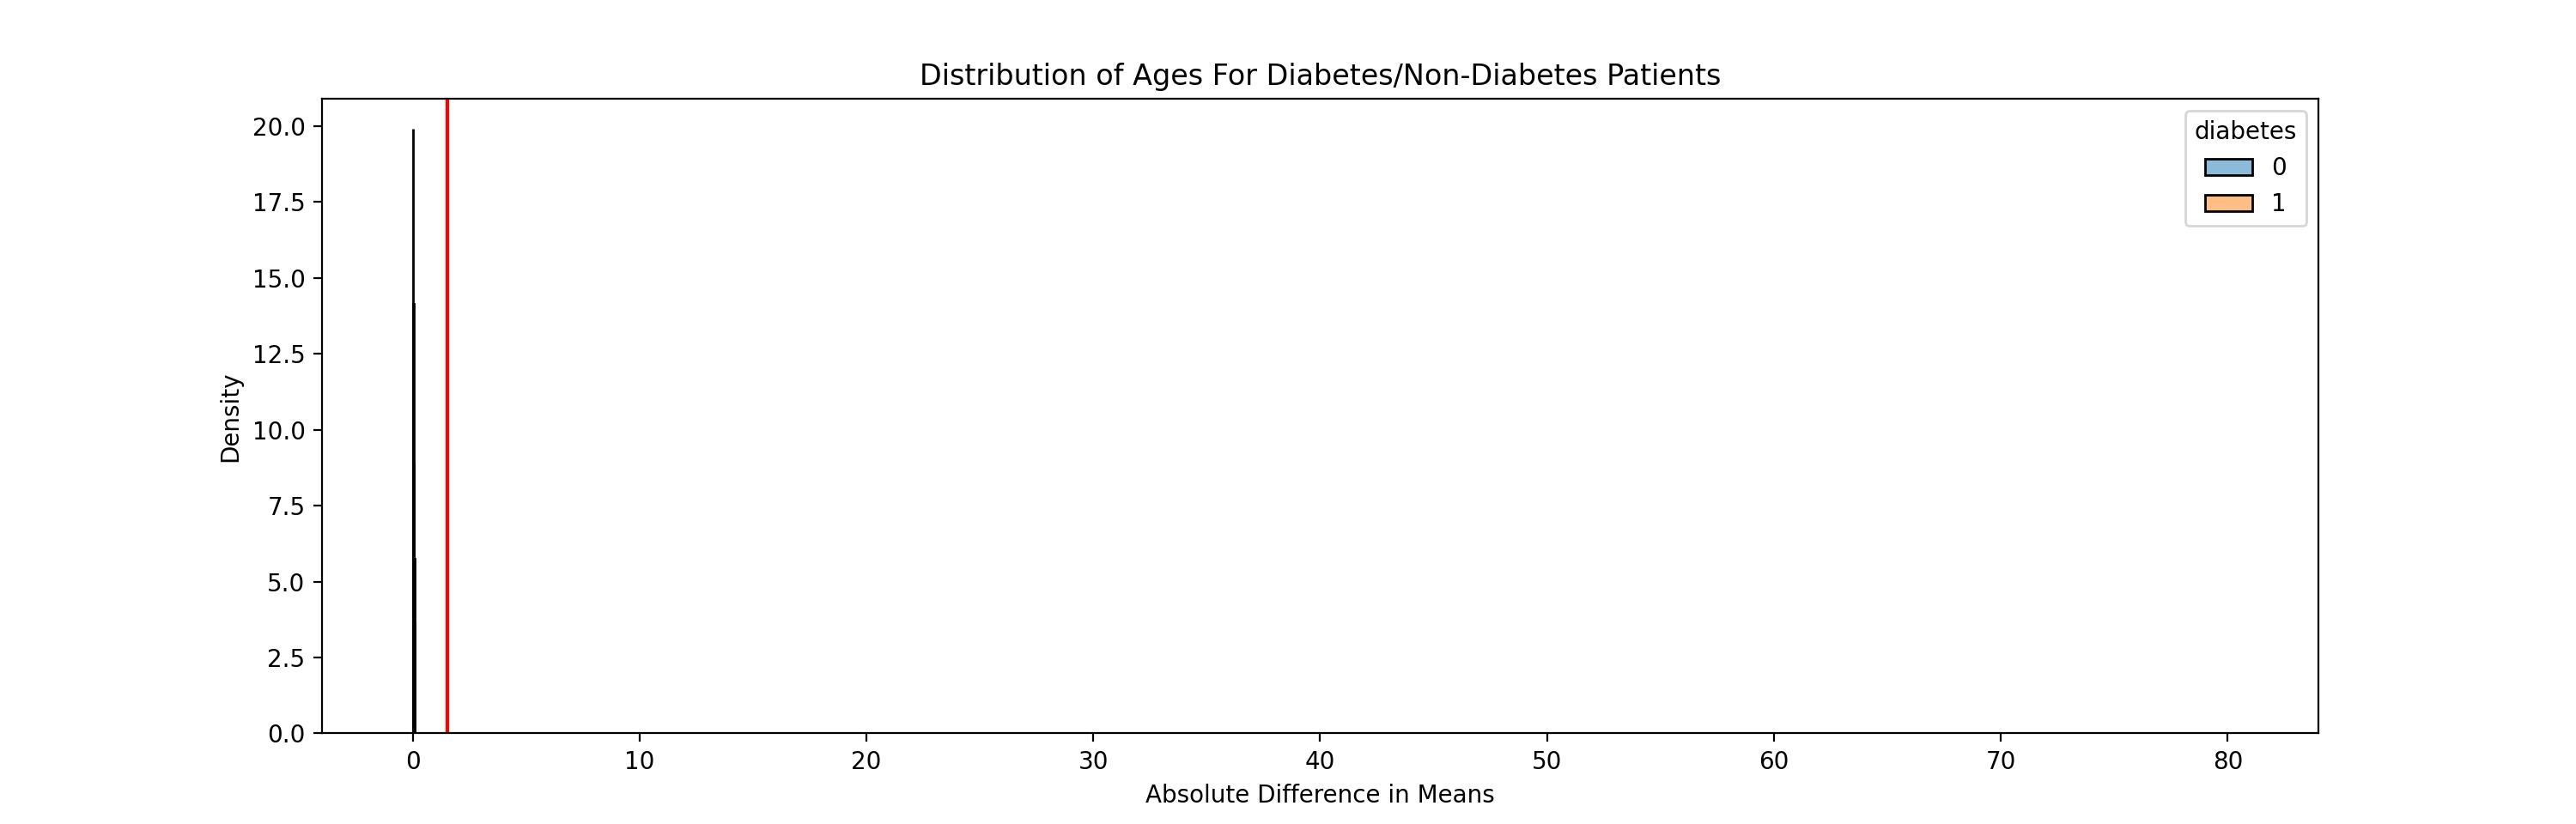

In [ ]:
perm_diffs = permutation(sample_df, 'bmi')
fig3, ax3 = plt.subplots()
ax3.set_xlabel('Absolute Difference in Means')
sns.histplot(data = perm_diffs, stat='density', bins=5).set(title='Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')
plt.axvline(hba1c_observed, color='red')
fig3.set_figwidth(15) 

In [ ]:
p_value_bg = (perm_diffs >= bmi_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the bmi levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### Ages

Null: The `age` of patients with and without diabetes have the same distribution

Alternative: The `age` of the patients with and without diabetes come from different distributions

In [ ]:
sns.histplot(x='age', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title="Distribution of Ages For Diabetes/Non-Diabetes Patients")

[Text(0.5, 1.0, 'Distribution of Ages For Diabetes/Non-Diabetes Patients')]

In [ ]:
age_observed = diffs.iloc[1, 3]
age_observed

13.167072170394988

In [ ]:
p_value_bg = (perm_diffs >= age_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the ages of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

### Relationships Between Different Varibles

Since we are trying to predict which features correlates with blood_glucose the most we wanted to see some of the relationships between blood_glucose and other variables individually.

<IPython.core.display.Javascript object>


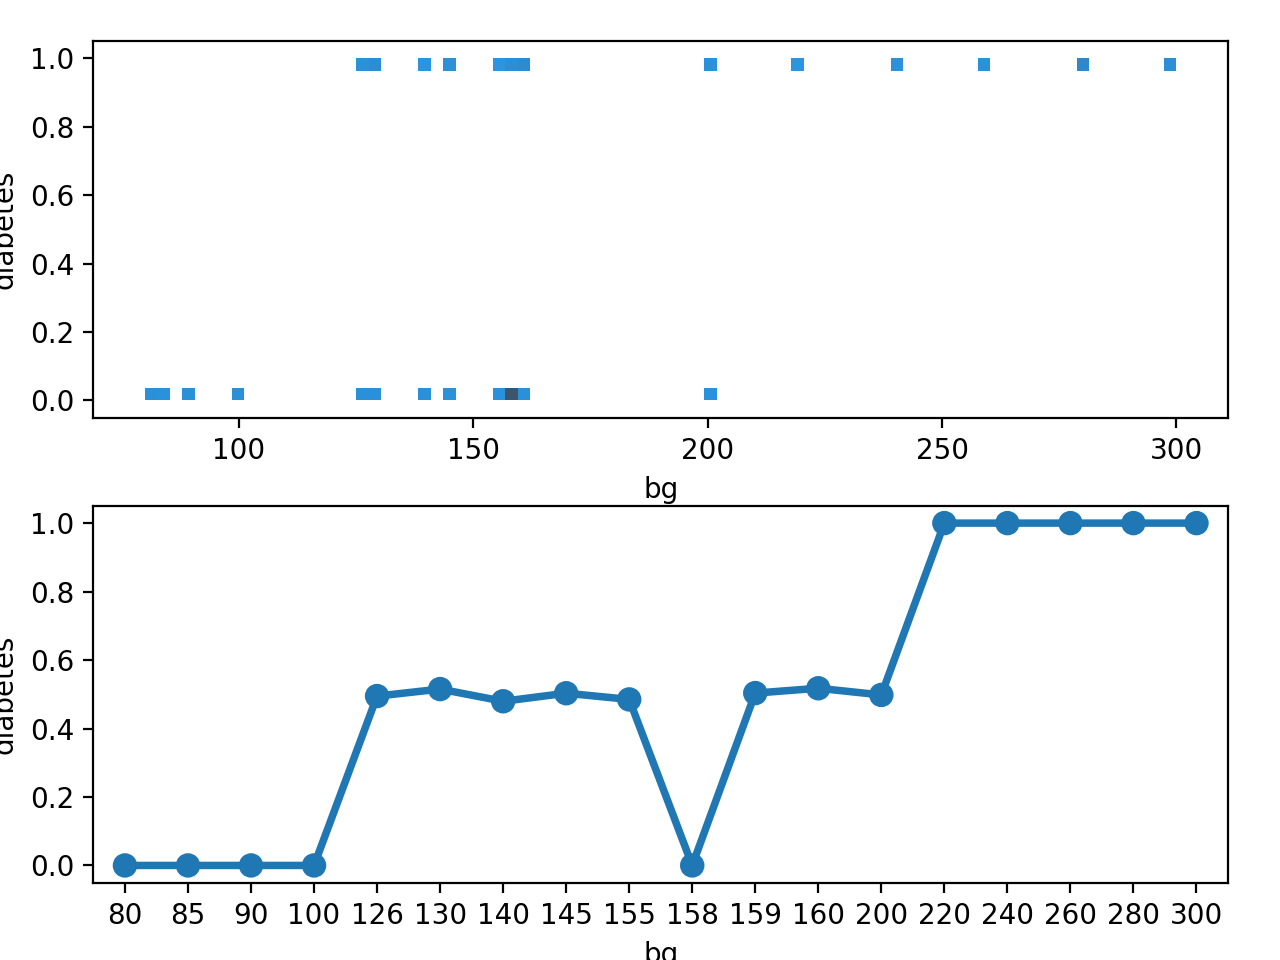

<AxesSubplot:xlabel='bg', ylabel='diabetes'>

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='diabetes', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='diabetes', data=sample_df, ax=ax[0])

This plot shows the relationship between diabetes and blood_glucose levels. Since diabetes is a binary variable, we can see that there are some values of blood_glucose that occur in both diabetes and non-diabetes patients (range from 100, 200). There are also values that of blood glucose that only occur in the diabetes patients (>200), knowing this information we can analyze other variables in relation to blood glucose level and put it into perspective of diabetes and non-diabetes patients.

<IPython.core.display.Javascript object>


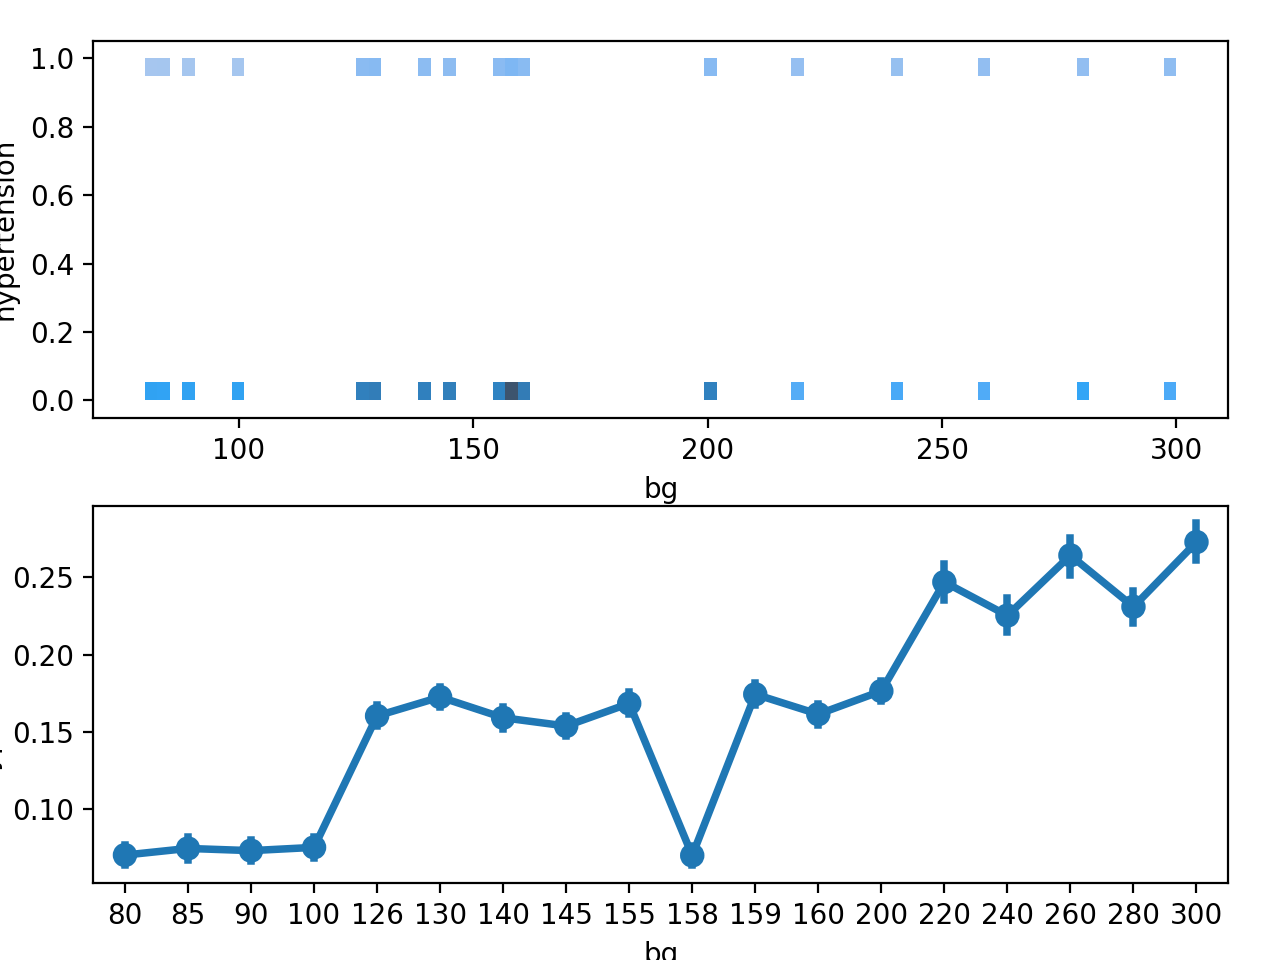

<AxesSubplot:xlabel='bg', ylabel='hypertension'>

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='hypertension', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='hypertension', data=sample_df, ax=ax[0])


Here we see that hypertension occurs in people of all blood glucose levels however, on average as the blood glucose level increases the higher the likelihood that the person has hypertension.

<IPython.core.display.Javascript object>


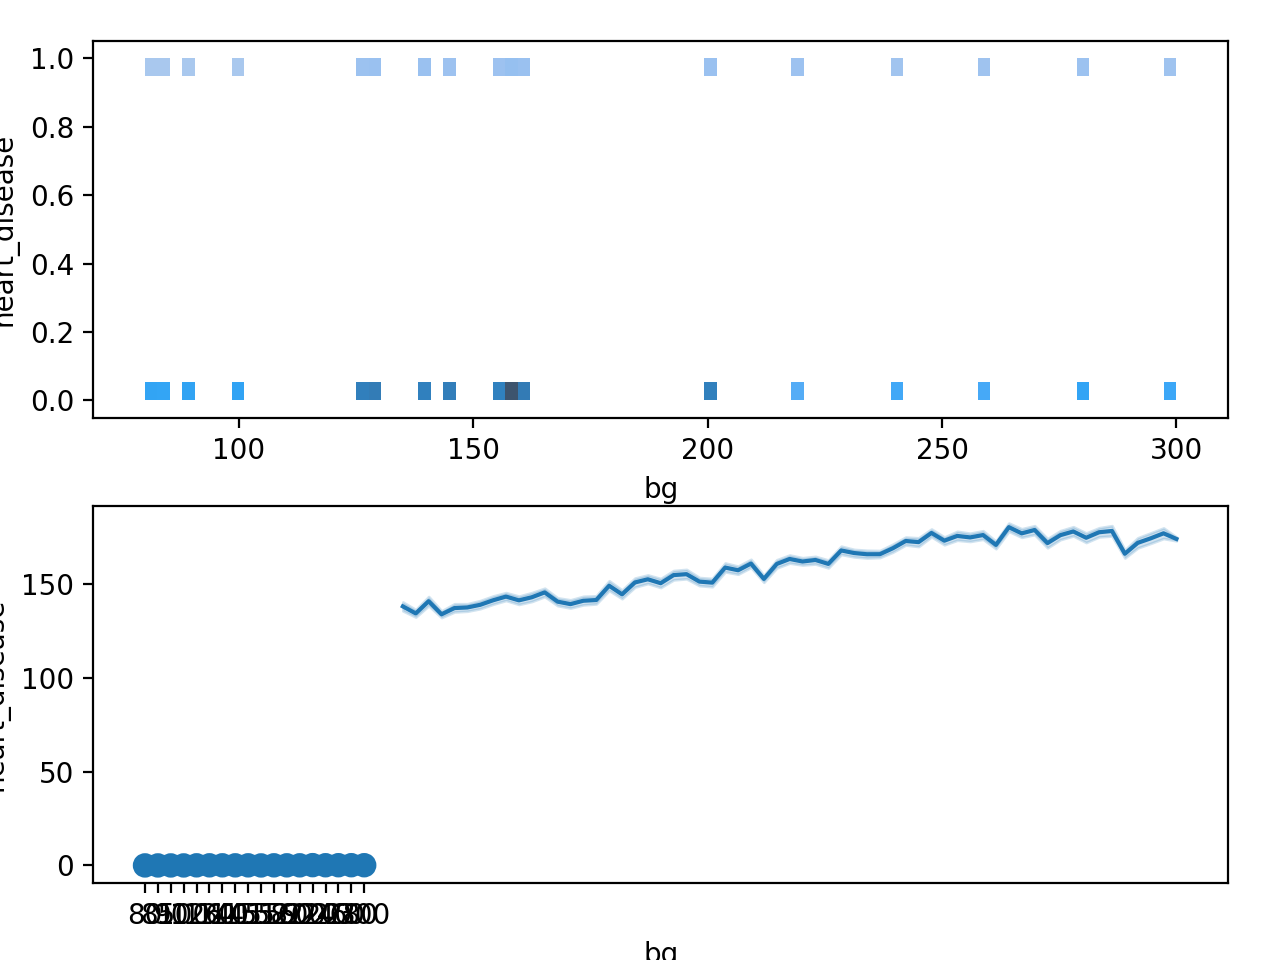

<AxesSubplot:xlabel='bg', ylabel='heart_disease'>

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='heart_disease', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='heart_disease', data=sample_df, ax=ax[0])

We see a similar trend in heart_disease. Heart disease occurs in patients of all ages, however, as the blood glucose increases the likelihood of the heart_disease increases as well. Looking back at our bg vs. diabetes graph, we know that the non-diabetes patients fall within the 80 to 200 blood glucose range. Heart disease and hypertension levels within that range tend to increase. Same goes for the range over 200, so we would want to explore both of these features as predictors of blood glucose levels in diabetes and non-diabetes patients

Another plot we want to explore is age vs. bg levels. As you can see below, the blood glucose levels increase as people age, there is a strong positive correlation.

In [ ]:
# sns.lineplot(x='age', y='bg', hue='diabetes', data=sample_df)
sns.lineplot(x='age', y='bg', data=sample_df)

<AxesSubplot:xlabel='bg', ylabel='heart_disease'>

## Using Linear Regression to find the best features

#### How well does age predict blood glucose levels?

In [ ]:
df0 = df[df['diabetes'] == 0]
df1 = df[df['diabetes'] == 1]

On the whole dataset

In [ ]:
#split the data into train and test
X = np.array(sample_df['age']).reshape((-1, 1))
y = np.array(sample_df['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

55.760383088317944

On the diabetes patients

In [ ]:
#split the data into train and test
X = np.array(df1['age']).reshape((-1, 1))
y = np.array(df1['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

58.5149290810686

On the non-diabetes patients

In [ ]:
#split the data into train and test
X = np.array(df0['age']).reshape((-1, 1))
y = np.array(df0['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

34.32799194869588

#### Rating Features On the Whole Dataset

In [ ]:
#define necessary features
features = ['age', 'bmi', 'hba1c']
#splite into train and test
X = np.array(sample_df.loc[:,features]).reshape((-1, 3))
y = np.array(sample_df['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#standardize all of the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#predict with linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

53.10888650682715

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,hba1c,15.168123
0,age,8.632662
1,bmi,5.934461


#### Rating Features on the non-diabetes patients

In [ ]:
#define the features
features = ['age', 'bmi', 'hba1c']
#split into train and test sets
X = np.array(df0.loc[:,features]).reshape((-1, 3))
y = np.array(df0['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#fit and predict to linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

34.330341881270726

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
2,hba1c,0.139120
1,bmi,0.118313
0,age,0.097183


#### Rating Features on the diabetes patients

In [ ]:
#define the features
features = ['age', 'bmi', 'hba1c']
#split into train and test sets
X = np.array(df1.loc[:,features]).reshape((-1, 3))
y = np.array(df1['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#fit and predict to linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

58.59826710580004

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
0,age,1.798097
1,bmi,1.667859
2,hba1c,0.566682


## PCA

### Whole dataset

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['age', 'hypertension', 'heart_disease', 'bmi', 'hba1c', 'bg']

data_all = StandardScaler().fit_transform(df.loc[:, features].values) # normalizing the features

pca_all = PCA()
PC_all = pca_all.fit_transform(data_all)

pca_all.explained_variance_ratio_

array([0.25868871, 0.1808441 , 0.16238092, 0.1432022 , 0.13493648,
       0.11994759])

In [ ]:
abs(pca_all.components_[0])

array([0.51392136, 0.4516009 , 0.41552963, 0.24893859, 0.38229083,
       0.38879286])

From greatest to least: `age`, `hypertension`, `heart_disease`, `bg`, `hba1c`, `bmi`

In the entire dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. 

### Non diabetic

In [ ]:
data_nondiabetic = StandardScaler().fit_transform(df0.loc[:, features].values) # normalizing the features

pca_nondiabetic = PCA()
PC_nondiabetic = pca_nondiabetic.fit_transform(data_nondiabetic)

pca_nondiabetic.explained_variance_ratio_

array([0.22734364, 0.17067367, 0.16694338, 0.1662953 , 0.14568562,
       0.12305839])

In [ ]:
abs(pca_nondiabetic.components_[0])

array([6.32994518e-01, 5.41993670e-01, 5.33007257e-01, 1.46498483e-01,
       1.41142694e-03, 5.18379547e-04])

From greatest to least: `age`, `hypertension`, `heart_disease`, `bmi`, `hba1c`, `bg`

In the nondiabetic subset of the dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. `hypertension` and `heart_disease` are also quite large.

### Diabetic

In [ ]:
data_diabetic = StandardScaler().fit_transform(df1.loc[:, features].values) # normalizing the features

pca_diabetic = PCA()
PC_diabetic = pca_diabetic.fit_transform(data_diabetic)

pca_diabetic.explained_variance_ratio_

array([0.22234018, 0.17286144, 0.16833244, 0.16519725, 0.15253172,
       0.11873698])

In [ ]:
abs(pca_diabetic.components_[0])

array([0.6764846 , 0.17709617, 0.51460062, 0.49384099, 0.03775497,
       0.0297888 ])

From greatest to least: `age`, `heart_disease`, `bmi`, `hypertension`, `hba1c`, `bg`

In the diabetic subset of the dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. `hypertension` and `bmi` are also quite large.